<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tutorial 1 Part 1 - Sequential Probability Ratio Test

Please execute the cell below to initialize the notebook environment

In [1]:
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
from scipy import stats

import matplotlib.pyplot as plt    # import matplotlib

In [2]:
#@title Figure Settings
#@ Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
# %config InlineBackend.figure_format = 'retina'

In [3]:
#@title Helper functions
def simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_samples):
  """Helper function for Exercise 1"""

  evidence_history_list = []
  print("#Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, data = simulate_SPRT_fixedtime(sigma, stop_time)
    print("{}\t{:f}\t{}".format(i,evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence),'--',c='red',alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time stopping rule")
  
  plt.show(fig)

def simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Helper function for Exercise 2"""
  accuracy_list, _ = simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample=num_sample)
  
  fig, ax = plt.subplots()
  ax.plot(stop_time_list,accuracy_list)
  ax.set_xlabel('Stop Time')
  ax.set_ylabel('Average Accuracy')

  plt.show(fig)

def simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha):
  """Helper function for Exercise 3"""
  # calculate evidence threshold from error rate
  threshold = threshold_from_errorrate(alpha)

  # run simulation
  evidence_history_list = []

  print("#Trial\tTime\tCumulated Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, data = simulate_SPRT_threshold(sigma, threshold, batch_size=10)
    print("{}\t{}\t{:f}\t{}".format(i,len(data), evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.repeat(threshold,maxlen_evidence + 1),c="red")
  ax.plot(-np.repeat(threshold,maxlen_evidence + 1),c="red")
  ax.plot(np.zeros(maxlen_evidence + 1),'--',c='red',alpha=0.5)

  for evidences in evidence_history_list:
      ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0],evidences]))
  
  ax.set_xlabel("Time")
  ax.set_ylabel("Cumulated log likelihood ratio")
  ax.set_title("Log likelihood ratio trajectories under the threshold rule")
  
  plt.show(fig)

def simulate_and_plot_speed_vs_accuracy(sigma, threshold_list, num_sample):
  """Helper function for Exercise 4"""
  accuracy_list, decision_speed_list = simulate_accuracy_vs_speed(sigma, threshold_list, num_sample=num_sample)

  fig, ax = plt.subplots()
  ax.plot(decision_speed_list, accuracy_list, linestyle="--", marker="o")
  ax.plot([0.0, 1.0], [0.5, 0.5], c='red')  # plot baseline for random choice
  ax.set_xlabel("Average Decision Speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(bottom=0.45)
  
  plt.show(fig)

# Introduction 

Video available at https://youtu.be/3CG92WsTk4Q


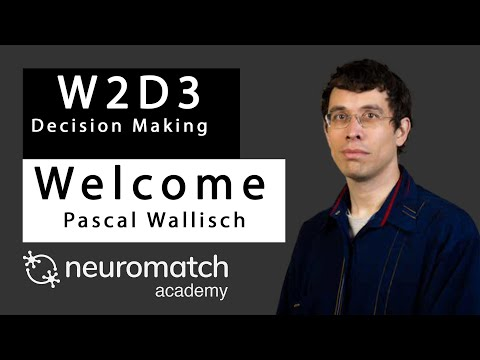

In [4]:
#@title Video 1 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="3CG92WsTk4Q", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Tutorial objectives
In this tutorial, we will consider a simplified random dot motion task. On each trial $i$, we are shown a dot moving at velocity $v_i$, either in either a leftward ($v<0$) or rightward ($v>0$) direction. Although the dots' velocity varies from trial to trial, the set of all $v_i$ are  generated by a fixed probability distribution, which we know to be either:
$$
\\
\begin{eqnarray}
p_L &=& \mathcal{N}(-1,\; \sigma^2) \\
&&\textrm{or} \\
p_R &=& \mathcal{N}(+1,\; \sigma^2) \\
\end{eqnarray} 
\\
$$
We want to determine which of these two possibilities is the true data generating distribution. 

In W2D1, we learned how to choose between possibilities based on the relative weight of the evidence. Depending on the sensory evidence and our prior experience, we learned to choose between these *two* options: accepting hypothesis $H_L$, that the data comes from the $p_L$ distribution, or accepting $H_R$, that it comes from $p_R$. 

Here, we add a *third* option: choose to collect more evidence before making a decision.

---

In this notebook we will perform a *Sequential Probability Ratio Test* between two hypotheses $H_L$ and $H_R$ by running simulations of a *Drift Diffusion Model (DDM)*. 

As independent and identically distributed(*i.i.d*) samples from the true data-generating distribution coming in, we accumulate our evidence linearly until a certain criterion is met before deciding which hypothesis to accept.  Two types of stopping criterion/stopping rule will be implemented: after seeing a fixed amount of data, and after the likelihood ratio passes a pre-defined threshold. Due to the noisy nature of observations, there will be a *drifting* term governed by expected mean output and a *diffusion* term governed by observation noise.

In this tutorial, you will

* Simulate Drift-Diffusion Model with different stopping rules.
* Observe the relation between accuracy and reaction time, get an intuition about the speed/accuracy tradeoff.


---

### Sequential Probability Ratio Test(SPRT)


<img src="https://drive.google.com/uc?export=view&id=1byiUWthtmDAEcevZXOobHgvpZOvVnSDX" alt="drawing" width="400"/>


Suppose we receive a sequence of independent samples from distribution $p$. We know that $p$ is from $\{p_0,p_1\}$ determined by a binary latent variable $x$ and need to test between the two hyptheses:

$H_L: p=p_L \text{ or } x=0$

$H_R: p=p_R \text{ or } x=1$

When we see $n$ samples $\{x_{1}...x_n\}$, we want to calculate the total log likelihood ratio as our evidence for decision:

$$S_n = \log \frac{\prod_{i=1}^n p_R(x_i)}{\prod_{i=1}^n p_L(x_i)} = \sum_{i=1}^n \log p_R(x_i) - \sum_{i=}^n \log p_L(x_i) \tag{1}$$

Due to the independence of samples, this can be calculated in a incremental way when new data points come in sequentially:

$$ S_n =  S_{n-1} + \log \frac{p_R(x_n)}{p_L(x_n)} = S_{n-1} + \log \Lambda_n \tag{2}$$

The stopping rule can be implemented in two ways:



1. Fixed time 

Make a decision based on $S_n$ immediately when we have collected $n$ samples. That is, accept $H_R$ if $S_n > 0$, accept $H_L$ if $S_n < 0$, and accept $H_R$ with probability $\frac{1}{2}$ if $S_n = 0$. The significance level or desired error rate $\alpha$ can then be determined as 

$$\alpha = \frac{1}{1+\exp(|S_n|)} \tag{4}$$

2. Thresholding 

We assume equal probability to make a false positive decision and to make a false negative decision, and denote it with $\alpha$. Then we accept hypothesis $H_R$ if $S_n \ge b$ or accept hypothesis $H_L$ if $S_n \le a$ where the thresholds are determined by 

$$a=\log \frac{\alpha}{1-\alpha},b=\log \frac{1-\alpha}{\alpha} \tag{3}$$


# SPRT as a Drift Diffusion Model (DDM)

Video available at https://youtu.be/a-O5n_d5tOA


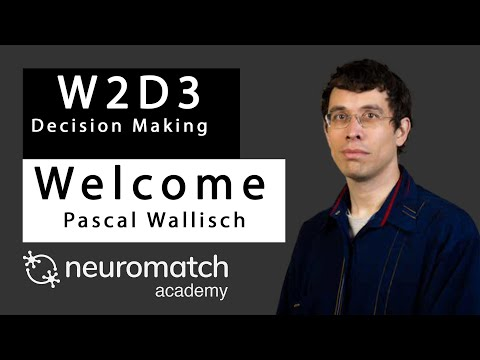

In [5]:
#@title Video 2
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="a-O5n_d5tOA", width=854, height=480, fs=1, start=0, end=40)
print("Video available at https://youtu.be/" + video.id)
video



SPRT as a Drift Diffusion Model (DDM)

Let's assume two different Gaussian observation models conditioned on discrete latent variable $z$ 

$$p_L(x|z=0) = \mathcal{N}(\mu_L,\sigma_L^2)$$

$$p_R(x|z=1) = \mathcal{N}(\mu_R,\sigma_R^2)$$

Then the log likelihood ratio for a single data point $x_i$ is 

$$ \log \Lambda_i = \log \frac{\sigma_L}{\sigma_R} -0.5 \biggr[\frac{(x_i-\mu_1)^2}{\sigma_R^2} - \frac{(x_i-\mu_L)^2}{\sigma_L^2}\biggl] \tag{5}$$

Without loss of generality, let's further assume the true data generating distribution is $p_R$. In this case $x_i$ can be expressed as $x_i = \mu_R + \sigma_R \epsilon$ where $\epsilon$ comes from a standard Gaussian. The foregoing formula can then be rewritten as 

$$
\log \Lambda_i = \bigg( \log \frac{\sigma_L}{\sigma_R} + 0.5 \frac{(\mu_R-\mu_L)^2}{\sigma_L^2} \bigg) + \bigg( \frac{\mu_R-\mu_L}{\sigma_L^2}\epsilon -0.5\big[1-(\frac{\sigma_R}{\sigma_L})^2\big]\epsilon^2  \bigg) \tag{6}
$$

where the first two constant terms serve as the *drifting* part and the last terms are the *diffusion* part. If we further let $\sigma_L=\sigma_R$, we can get rid of the quadratic term and this reduces to the classical discrete drift-diffusion equation where we have analytical solutions for mean and expected auto-covariance:

$$
\log \Lambda_i = 0.5 \frac{(\mu_R-\mu_L)^2}{\sigma_L^2}  + \frac{\mu_R-\mu_L}{\sigma_L^2}\epsilon, \text{where } \epsilon \sim \mathcal{N}(0,1)
$$



# 1. Simulating DDM with fixed-time stopping rule


Video available at https://youtu.be/TpqMzI0iZJ8


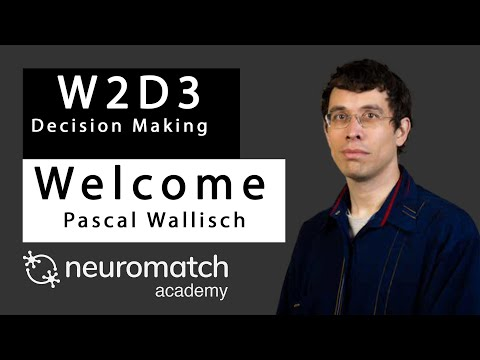

In [6]:
#@title Video 3a
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="TpqMzI0iZJ8", width=854, height=480, fs=1, start=0, end=40)
print("Video available at https://youtu.be/" + video.id)
video

Exercise 1
---

Assume we are performing a random dot motion task and at each time we see a moving dot with velocity $x_t$. All data points are sampled from the same distribution $p$, which is either $p_L=\mathcal{N}(-\mu,\sigma^2)$ or $p_R=\mathcal{N}(\mu,\sigma^2)$. Let's now generate some simulated data under this setting and perform SPRT using the fixed time stopping rule. 

In this exercise, without loss of generality, we assume the true data-generating model is $p_R$.

* Complete the code in function `simulate_SPRT_fixedtime` to create two Gaussian random variables to represent our observation models.
* Complete the function `log_likelihood_ratio` to calculate log likelihood ratio for a sequence of data points
* Complete the code in function `simulate_SPRT_fixedtime` to calculate cumulated evidence given a list of individual evidences
* Run 10 simulations and plot the DDM traces by commenting out our provided code



In [7]:
def log_likelihood_ratio(xvec,p0,p1):
    """
    Given a sequence(vector) of observed data, calculate the log of likelihood ratio of p1 and p0

    Args:
        xvec (numpy vector): a vector of scalar measurements 
        p0 (Gaussian random variable): a normal random variable with `logpdf` method 
        p1 (Gaussian random variable): a normal random variable with `logpdf` method 

    Returns:
        llvec: a vector of log likelihood ratios for each input data point
    """
    ################################################################################
    ## Insert your code here to:
    ##      Calculate the log of likelihood ratios of `p1` and `p0` given a vector of measurements
    ##      Hint: using `p1.logpdf`
    ################################################################################
    raise NotImplementedError("Function `log_likelihood_ratio` incomplete")


def simulate_SPRT_fixedtime(sigma, stop_time, true_dist=1):
    """
    Simulate a Sequential Probability Ratio Test with fixed time stopping rule.
    Two observation models are 1D Gaussian distributions N(1,sigma^2) and N(-1,sigma^2).

    Args:
        sigma (float): standard deviation 
        stop_time (int): number of samples to take before stopping

    Returns:
        evidence_history (numpy vector): the history of cumulated evidence given generated data
        decision (int): 1 for pR, 0 for pL
        data (numpy vector): the generated sequences of data in this trial 
    """
    muL = -1.0
    muR = 1.0 
    ################################################################################
    ## Insert your code here to:
    ##      Create two Gaussian variables `pL` and `pR` with mean `muL` and `muR` respectively and same std. `sigma`
    ##      Hint: using `stats.norm(...)` to construct an instance of 1D Gaussian distribution
    ################################################################################


    if 'pL' not in locals() or 'pR' not in locals():
        raise NotImplementedError("Function `simulate_SPRT_fixedtime` incomplete")

    # Generate a random sequence of data 
    if true_dist == 1:
        data = pR.rvs(size=stop_time)
    else: 
        data = pL.rvs(size=stop_time)
    
    # Calculate cumulated evidence
    ll_vec = log_likelihood_ratio(data, pL, pR)
    ################################################################################
    ## Insert your code here to:
    ##      Calculate cumulated evidence given a vector of individual evidences 
    ##      Hint: use `np.cumsum`
    ################################################################################
    evidence_history = None

    if evidence_history is None:
        raise NotImplementedError("Function `simulate_SPRT_fixedtime` incomplete")

    # Make decision
    if evidence_history[-1] > 0:
        decision = 1
    elif evidence_history[-1] < 0:
        decision = 0 
    else: 
        decision = np.random.randint(2)
    
    return evidence_history, decision, data 

sigma = 3.5  # standard deviation for pL and pR
num_sample = 10  # number of simulations to run for each stopping time
stop_time = 150 # stopping time


#######p#########################################################################
## Un-comment the following code block after completing this exercise
################################################################################
#plot_and_simulate_SPRT_fixedtime(sigma, stop_time, num_sample)

#Trial	Total_Evidence	Decision
0	30.391038	1
1	28.268360	1
2	23.565061	1
3	10.656525	1
4	11.965876	1
5	10.792768	1
6	19.587413	1
7	26.250462	1
8	16.945051	1
9	29.679950	1


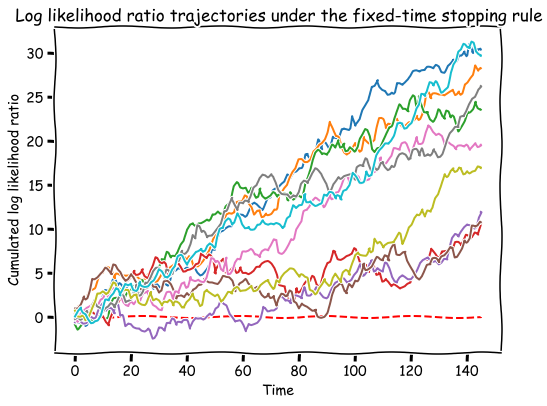

In [8]:
# to_remove solution
def log_likelihood_ratio(xvec,p0,p1):
    """
    Given a sequence(vector) of observed data, calculate the log of likelihood ratios under 
    distributions p0 and p1

    Args:
        xvec (numpy vector): a vector of scalar measurements 
        p0 (Gaussian random variable): a normal random variable with `logpdf` method 
        p1 (Gaussian random variable): a normal random variable with `logpdf` method 

    Returns:
        llvec: a vector of log likelihood ratios for each input data point
    """
    return p1.logpdf(xvec) - p0.logpdf(xvec)


def simulate_SPRT_fixedtime(sigma, stop_time, true_dist=1):
    """
    Simulate a Sequential Probability Ratio Test with fixed time stopping rule.
    Two observation models are 1D Gaussian distributions N(1,sigma^2) and N(-1,sigma^2).

    Args:
        sigma (float): standard deviation 
        stop_time (int): number of samples to take before stopping

    Returns:
        evidence_history (numpy vector): the history of cumulated evidence given generated data
        decision (int): 1 for pR, 0 for pL
        data (numpy vector): the generated sequences of data in this trial 
    """
    muL = -1.0
    muR = 1.0 
    
    pL = stats.norm(muL, sigma) 
    # student
    pR = stats.norm(muR, sigma)

    # Generate a random sequence of data 
    if true_dist == 1:
        data = pR.rvs(size=stop_time)
    else: 
        data = pL.rvs(size=stop_time)
    
    # Calculate cumulated evidence
    ll_vec = log_likelihood_ratio(data, pL, pR)
    evidence_history = np.cumsum(ll_vec)

    # Make decision
    if evidence_history[-1] >0:
        decision = 1
    elif evidence_history[-1] <0:
        decision = 0 
    else: 
        decision = np.random.randint(2)
    
    return evidence_history, decision, data 

sigma = 3.5  
num_sample = 10  # number of simulations to run for each stopping time
stop_time = 146 

with plt.xkcd():
  simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample)

Now let's look at how the dynamics change if you change the noise level and stopping time. 



* Play with different noise levels and stopping times and observe the corresponding trajectories. Once you have completed exercise 1, check the box to enable the demo.

*Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure

#Trial	Total_Evidence	Decision
0	49.539465	1
1	49.014654	1
2	42.317223	1
3	35.553389	1
4	52.393774	1
5	54.418002	1
6	61.205527	1
7	47.963342	1
8	53.231520	1
9	56.579111	1


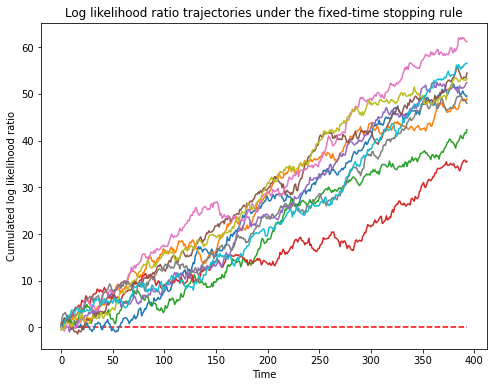

In [9]:
#@title # Interactive Demo: Noise level and stopping time { run : "auto" }

sigma = 4  #@param {type:"slider", min:0.05, max:10.0, step:0.05}
num_sample = 10  # number of simulations to run for each stopping time
stop_time = 394 #@param {type:"slider", min:5, max:500, step:1}
################################################################################
## Un-comment the following code block after complete the exercise above
################################################################################
try:
  simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample)
except:
  print("Complete Exercise 1 first")

# 2. Accuracy vs. Stopping time


Video available at https://youtu.be/TpqMzI0iZJ8


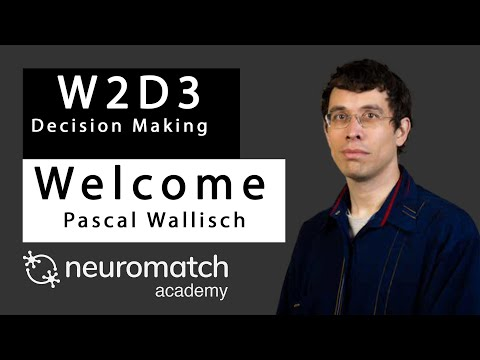

In [10]:
#@title Video 3b
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="TpqMzI0iZJ8", width=854, height=480, fs=1, start=41)
print("Video available at https://youtu.be/" + video.id)
video

Exercise 2
---

If you stop taking samples too early, e.g., make a decision after only seeing 5 samples, or there's a huge amount of observation noise that buries the signal, you are likely to be driven by observation noise to a negative cumulated log likelihood ratio and thus make a wrong decision. You could get a sense of this by increasing noise level or decreasing stopping time in the last exercise.

Now let's look at how decision accuracy varies with the number of samples we see quantitatively. First we'll fix our observation noise level. In this exercise you will run several repeated simulations for a certain stopping time to calculate the average decision accuracy. Do this for a range of stopping times and plot the relation between average decision accuracy and stopping time. You should get a positive correlation between these two quantities.

* Choose a noise level. For example, $\sigma=3$  
* Complete the function `simulate_accuracy_vs_stoptime` to simulate and compute corresponding average accuracies for a list of stopping times.
* Plot accuracy versus stopping time using the pre-written codes 




In [11]:
sigma = 4.65  # standard deviation for observation noise
num_sample = 200  # number of simulations to run for each stopping time
# list of stopping times to play with
stop_time_list = list(range(1,150,10))

def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample=100):
    """
    Calculate the average decision accuracy vs. stopping time by running repeated SPRT simulations
    for each stop time 

    Args:
        sigma (float): standard deviation for observation model 
        stop_list_list (list-like object): a list of stopping times to run over
        num_sample (int): number of simulations to run per stopping time 

    Returns:
        accuracy_list: a list of average accuracies corresponding to input `stop_time_list`
        decisions_list: a list of decisions made in all trials
    """
    accuracy_list = []
    decisions_list = []
    for stop_time in stop_time_list:
        decision_list = []
        ################################################################################
        ## Insert your code here to:
        ##      * Run `num_sample` repeated simulations, collect decision into `decision_list`
        ##      * Calculate average decision accuracy as `accuracy`
        ################################################################################
        for i in range(num_sample):
            # _, decision,_= ...
            # append to container
            pass 
        # accuracy = ...

        if not 'accuracy' in locals():
            raise NotImplementedError("function `simulate_accuracy_vs_stoptime` incomplete")

        accuracy_list.append(accuracy)
        decisions_list.append(decision_list)

    return accuracy_list, decisions_list

################################################################################
## Un-comment the following code  after completing this exercise
################################################################################
# simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)

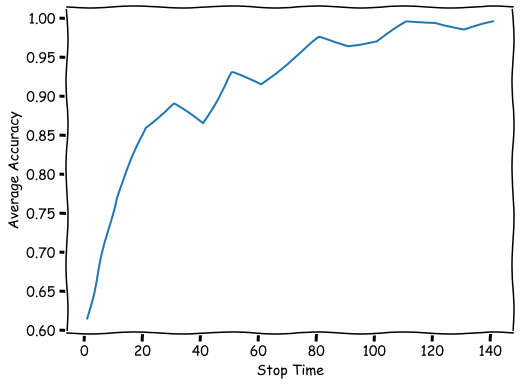

In [12]:
# to_remove solution

sigma = 4.65  
num_sample = 200  # number of simulations to run for each stopping time
stop_time_list = list(range(1,150,10)) # list of stopping times to play with

def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample=100):
    """
    Calculate the average decision accuracy vs. stopping time by running repeated SPRT simulations
    for each stop time 

    Args:
        sigma (float): standard deviation for observation model 
        stop_list_list (list-like object): a list of stopping times to run over
        num_sample (int): number of simulations to run per stopping time 

    Returns:
        accuracy_list: a list of average accuracies corresponding to input `stop_time_list`
        decisions_list: a list of decisions made in all trials
    """
    accuracy_list = []
    decisions_list = []
    for stop_time in stop_time_list:
        decision_list = []
        for i in range(num_sample):
            _, decision,_=simulate_SPRT_fixedtime(sigma, stop_time)
            decision_list.append(decision)
        accuracy = sum(decision_list) / len(decision_list)
        accuracy_list.append(accuracy)
        decisions_list.append(decision_list)

    return accuracy_list, decisions_list

accuracy_list, _ = simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample=num_sample)
with plt.xkcd(): 
    simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)



**Suggestions** 

* Play with difference values of  noise level `sigma` and observe how that affects the curve. What does that mean?    *Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure


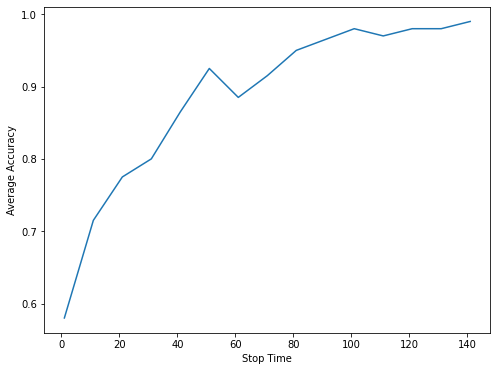

In [13]:
#@title Interactive Demo: Accuracy vs. Stopping Time { run : "auto"}

sigma = 5.5  #@param {type:"slider", min:0.05, max:10.0, step:0.05}
num_sample = 200  # number of simulations to run for each stopping time
# list of stopping times to play with
stop_time_list = list(range(1,150,10))

try:
  simulate_and_plot_accuracy_vs_stoptime(sigma, stop_time_list, num_sample)
except NotImplementedError:
  print("Complete Exercise 2 first")

# Simulate DDM with fixed thresholds


Exercise 3
---

In this exercise, we will use thresholding as our stopping rule and observe the behavior of the DDM. 

With thresholding stopping rule, we define a desired error rate and will continue making measurements until that error rate is reached. Experimental evidence suggested that evidence accumulation and thresholding stopping strategy happens at neuronal level (see [this article](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.29.051605.113038) for further reading).

* Complete the function `threshold_from_errorrate` to calculate the evidence threshold from desired error rate $\alpha$ as described in the formulas below. The evidence thresholds $th_L$ and $th_R$ for $p_L$ and $p_R$ are opposite of each other as shown below, so you can just return the absolute value.
$$
\begin{align}
 th_{L} &= \log \frac{\alpha}{1-\alpha} &= -th_{R} \\
 th_{R} &= \log \frac{1-\alpha}{\alpha} &= -th{_L}\\
 \end{align}
 $$

* Complete the function `simulate_SPRT_threshold` to simulate an SPRT with thresholding stopping rule given noise level and desired threshold 

* Run repeated simulations for a given noise level and a desired error rate visualize the DDM traces using our provided code 


In [14]:
def threshold_from_errorrate(alpha):
    """
    Calculate log likelihood ratio threshold from desired error rate `alpha`

    Args:
        alpha (float): in (0,1), the desired error rate

    Return:
        threshold: corresponding evidence threshold
    """
    ################################################################################
    ## Insert your code here to:    
    ##      * calculate the evidence threshold from desired error rate
    ################################################################################
    raise NotImplementedError("function `threshold_from_errorrate` incomplete")


def simulate_SPRT_threshold(sigma, threshold , true_dist=1, batch_size=100):
    """
    Simulate a Sequential Probability Ratio Test with thresholding stopping rule.
    Two observation models are 1D Gaussian distributions N(1,sigma^2) and N(-1,sigma^2).

    Args:
        sigma (float): standard deviation 
        threshold (float): desired log likelihood ratio threshold to achieve before making decision
        batch_size (int): generate and process data in batches instead of serially for speed. The size of each batch

    Returns:
        evidence_history (numpy vector): the history of cumulated evidence given generated data
        decision (int): 1 for pR, 0 for pL 
        data (numpy vector): the generated sequences of data in this trial 
    """
    muL = -1.0
    muR = 1.0 
    
    pL = stats.norm(muL, sigma) 
    pR = stats.norm(muR, sigma)

    has_enough_data = False 
    
    data = np.zeros(0)  
    evidence_history = np.zeros(0)
    current_evidence = 0.0
    while not has_enough_data:
        # generate a batch of data 
        if true_dist == 1:
            data_batch = pR.rvs(size=batch_size)
        else: 
            data_batch = pL.rvs(size=batch_size)

        # individual log likelihood ratios
        ll_batch = log_likelihood_ratio(data_batch, pL, pR)
        # cumulated evidence for this batch
        evidence_history_batch = np.cumsum(ll_batch) + current_evidence
        # update the collection of all data
        data = np.concatenate([ data, data_batch])
        # update the collection of all cumulated evidence history
        evidence_history = np.concatenate([evidence_history, evidence_history_batch])
        current_evidence = evidence_history[-1]
        
        # check if we've got enough data
        if np.abs(current_evidence) > threshold:
            has_enough_data = True 

    # find earliest time to cross threshold
    ################################################################################
    ## Insert your code here to:    
    ##      * Find the index of first data that crosses one of the thresholds
    ##      and assign that to `id_crossing`
    ##      Hint: use `np.argmax` on a vector of Bool numbers will give you the index of the 
    ##          first non-zero value
    ################################################################################
    
    if id_crossing not in locals():
        raise NotImplementedError("function `simulate_SPRT_threshold` incomplete")

    # discard redundant data because of  batching
    if len(data)-1 > id_crossing:
        data = data[:id_crossing + 1]
        evidence_history = evidence_history[:id_crossing+1]

    # Make decision 
    if evidence_history[-1] >0:
        decision = 1
    elif evidence_history[-1] <0:
        decision = 0 
    else: 
        decision = np.random.randint(2)

    return evidence_history, decision, data


sigma = 2.8  
num_sample = 10
log10_alpha = -6.5 #log10(alpha)
alpha = np.power(10.0,log10_alpha)


# Uncomment the line below to run the simulation and visualize the results
# simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)

#Trial	Time	Cumulated Evidence	Decision
0	35	9.473268	1
1	63	9.448373	1
2	30	9.269449	1
3	50	9.296225	1
4	83	9.483445	1
5	49	9.312395	1
6	97	9.653488	1
7	39	9.708780	1
8	74	9.921193	1
9	29	9.648659	1


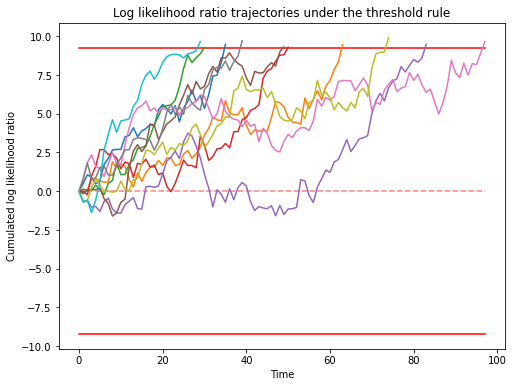

In [15]:
# to_remove solution

def threshold_from_errorrate(alpha):
    """
    Calculate log likelihood ratio threshold from desired error rate `alpha`

    Args:
        alpha (float): in (0,1), the desired error rate

    Return:
        threshold: corresponding evidence threshold
    """
    threshold = np.log((1-alpha)/alpha)
    return threshold

def simulate_SPRT_threshold(sigma, threshold , true_dist=1, batch_size=100):
    """
    Simulate a Sequential Probability Ratio Test with thresholding stopping rule.
    Two observation models are 1D Gaussian distributions N(1,sigma^2) and N(-1,sigma^2).

    Args:
        sigma (float): standard deviation 
        threshold (float): desired log likelihood ratio threshold to achieve before making decision
        batch_size (int): generate and process data in batches instead of serially for speed. The size of each batch

    Returns:
        evidence_history (numpy vector): the history of cumulated evidence given generated data
        decision (int): 1 for pR, 0 for pL 
        data (numpy vector): the generated sequences of data in this trial 
    """
    muL = -1.0
    muR = 1.0 
    
    pL = stats.norm(muL, sigma) 
    pR = stats.norm(muR, sigma)

    has_enough_data = False 
    
    data = np.zeros(0)  
    evidence_history = np.zeros(0)
    current_evidence = 0.0
    while not has_enough_data:
        # generate a batch of data 
        if true_dist == 1:
            data_batch = pR.rvs(size=batch_size)
        else: 
            data_batch = pL.rvs(size=batch_size)

        # individual log likelihood ratios
        ll_batch = log_likelihood_ratio(data_batch, pL, pR)
        # cumulated evidence for this batch
        evidence_history_batch = np.cumsum(ll_batch) + current_evidence
        # update the collection of all data
        data = np.concatenate([ data, data_batch])
        # update the collection of all cumulated evidence history
        evidence_history = np.concatenate([evidence_history, evidence_history_batch])
        current_evidence = evidence_history[-1]
        
        # check if we've got enough data
        if np.abs(current_evidence) > threshold:
            has_enough_data = True 

    # find earliest time to cross threshold
    id_crossing = np.argmax( np.abs(evidence_history)> threshold)
    # discard redundant data because of batching
    if len(data)-1 > id_crossing:
        data = data[:id_crossing + 1]
        evidence_history = evidence_history[:id_crossing+1]

    # Make decision 
    if evidence_history[-1] >0:
        decision = 1
    elif evidence_history[-1] <0:
        decision = 0 
    else: 
        decision = np.random.randint(2)

    return evidence_history, decision, data



sigma = 3.35  
num_sample = 10
log10_alpha = -4  #log10(alpha)
alpha = np.power(10.0,log10_alpha)

simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)

**Suggestion**

* Play with difference values of `alpha` and `sigma` and observe how that affects the dynamics of Drift-Diffusion Model. *Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure

#Trial	Time	Cumulated Evidence	Decision
0	103	13.645931	1
1	120	13.908627	1
2	291	13.704891	1
3	153	13.597201	1
4	153	13.694892	1
5	148	13.719644	1
6	183	13.679953	1
7	220	13.633841	1
8	137	13.996508	1
9	118	13.612481	1


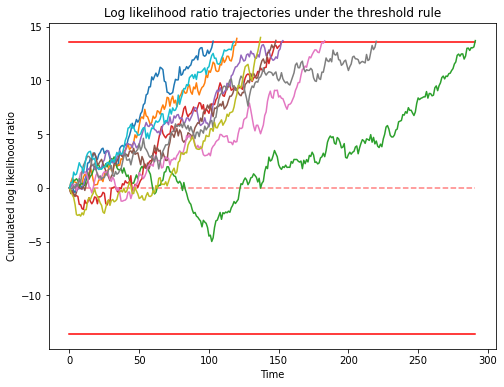

In [16]:
#@title Interactive Demo: Noise levels and thresholds { run : "auto"}
sigma = 5  #@param {type:"slider", min:0.05, max:5.0, step:0.05}
num_sample = 10
log10_alpha = -5.9 #@param {type:"slider", min:-8, max:-0.1, step:0.1}
alpha = np.power(10.0, log10_alpha)
threshold = threshold_from_errorrate(alpha)
# construct a simulation model
num_sample = 10

################################################################################
## Un-comment the following code block after completing the exercise above
################################################################################
try:
  simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)
except NotImplementedError:
  print("Finish exercise 3 first")

# Speed/Accuracy Tradeoff

---
### EXERCISE 4: 

The faster you make a decision (by allowing higher error rate $\alpha$), the lower your accuracy will be. This is known as the speed/accuracy tradeoff. To illustrate the speed/accuracy under thresholding stopping rule, let's run some simulations under differenct thresholds and look at how average decision speed changes with average decision accuracy. 

* Complete the function `simulate_accuracy_vs_speed` to simulate and compute average accuracies vs. average decision speeds for a list of error rates.

* We've set up a list of error rates. Run repeated simulations and collect average accuracy with average speed for each error rate in this list, and use our provided code to visualize the speed/accuracy tradeoff. You should see a negative correlation between speed and accuracy.


In [17]:
sigma = 3.95  
num_repeats = 500  # number of simulations to run for each error rate
alpha_list = np.power(10,list(range(-5,0)) + np.linspace(-0.9,-0.1,9).tolist())   # list of error rates

threshold_list = list(map(threshold_from_errorrate, alpha_list))

def simulate_accuracy_vs_speed(sigma, threshold_list, num_sample=100):
    """
    Calculate the average decision accuracy vs. average decision speed by running repeated SPRT simulations
    with thresholding stopping rule for each threshold

    Args:
        sigma (float): standard deviation for observation model 
        threshold_list (list-like object): a list of evidence thresholds to run over
        num_sample (int): number of simulations to run per stopping time 

    Returns:
        accuracy_list: a list of average accuracies corresponding to input `stop_time_list`
        decision_speed_list: a list of average decision speeds
    """
    decision_speed_list = []  # container for average decision speed for each alpha
    accuracy_list = [] # container for decision accuracy for each alpha
    for threshold in threshold_list:
        decision_time_list = [] # container for decision time for each simulation
        decision_list = [] # container for decision for every simulation
        for i in range(num_repeats):
            # run simulation and get decision of current simulation
            ################################################################################
            ## Insert your code here to:    
            ##      * run a simulation of SPRT with thresholding using function `simulate_SPRT_threshold`
            ##      * calculate decision time(number of data seen) from return values and assign that to `decision_time`
            ################################################################################
    
            if 'decision_time' not in locals():
                raise NotImplementedError("function `simulate_accuracy_vs_speed` incomplete")
            decision_list.append(decision)
            decision_time_list.append(decision_time)
        ################################################################################
        ## Insert your code here to:    
        ##      * Calculate decision speed given a list of decision times 
        ##      and assign that to variable `decision_speed`
        ################################################################################

        if 'decision_speed' not in locals():
            raise NotImplementedError("function `simulate_accuracy_vs_speed` incomplete")
        decision_accuracy = sum(decision_list) / len(decision_list)
        decision_speed_list.append(decision_speed)
        accuracy_list.append(decision_accuracy)

    return accuracy_list, decision_speed_list


################################################################################
## Un-comment the following code block after completing this exercise
################################################################################
# simulate_and_plot_speed_vs_accuracy(sigma, threshold_list, num_sample)

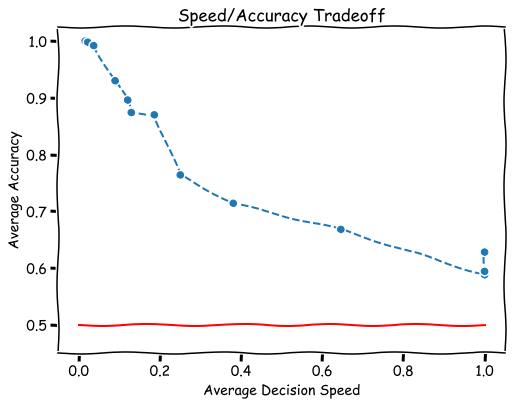

In [18]:
# to_remove solution

sigma = 3.95  
num_repeats = 500  # number of simulations to run for each error rate
alpha_list = np.power(10,list(range(-5,0)) + np.linspace(-0.9,-0.1,9).tolist())   # list of error rates

threshold_list = list(map(threshold_from_errorrate, alpha_list))

def simulate_accuracy_vs_speed(sigma, threshold_list, num_sample=100):
    """
    Calculate the average decision accuracy vs. average decision speed by running repeated SPRT simulations
    with thresholding stopping rule for each threshold

    Args:
        sigma (float): standard deviation for observation model 
        threshold_list (list-like object): a list of evidence thresholds to run over
        num_sample (int): number of simulations to run per stopping time 

    Returns:
        accuracy_list: a list of average accuracies corresponding to input `stop_time_list`
        decision_speed_list: a list of average decision speeds
    """
    decision_speed_list = []  # container for average decision speed for each alpha
    accuracy_list = [] # container for decision accuracy for each alpha
    for threshold in threshold_list:
        decision_time_list = [] # container for decision time for each simulation
        decision_list = [] # container for decision for every simulation
        for i in range(num_repeats):
            # run simulation and get decision of current simulation
            _, decision, data = simulate_SPRT_threshold(sigma, threshold)
            decision_time = len(data)
            decision_list.append(decision)
            decision_time_list.append(decision_time)
            
        decision_speed = np.mean(1.0 / np.asarray(decision_time_list))
        decision_accuracy = sum(decision_list) / len(decision_list)
        decision_speed_list.append(decision_speed)
        accuracy_list.append(decision_accuracy)

    return accuracy_list, decision_speed_list

accuracy_list, decision_speed_list = simulate_accuracy_vs_speed(sigma, threshold_list, num_sample=num_sample)

with plt.xkcd():
  simulate_and_plot_speed_vs_accuracy(sigma, threshold_list, num_sample)

**Suggestions**

* Play with difference values of  noise level `sigma` and observe how that affects the speed/accuracy tradeoff. *Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure

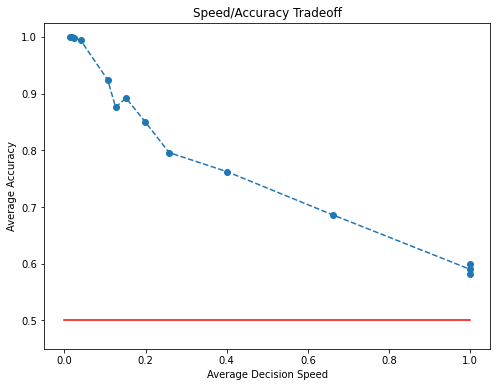

In [19]:
#@title Interactive Cell { run : "auto" }
sigma = 3.75  #@param {type:"slider", min:0.05, max:5.0, step:0.05}
num_repeats = 500  # number of simulations to run for each error rate
alpha_list = np.power(10,list(range(-5,0)) + np.linspace(-0.9,-0.1,9).tolist())   # list of error rates

################################################################################
## Un-comment the following code block after completing the exercise above
################################################################################
try:
  threshold_list = list(map(threshold_from_errorrate, alpha_list))
  accuracy_list, decision_speed_list = simulate_accuracy_vs_speed(sigma, threshold_list, num_sample=num_sample)
# # Plotting
  
  fig, ax = plt.subplots()
  ax.plot(decision_speed_list, accuracy_list, linestyle="--", marker="o")
  ax.plot([0.0, 1.0], [0.5, 0.5], c='red')  # plot baseline for random choice
  ax.set_xlabel("Average Decision Speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(bottom=0.45)
  plt.show()
  
except NotImplementedError:
  print("Finish the functions above first.")


# Summary

Good job! By simulating Drift Diffusion Models to perform decision making, you have learnt how to 

1. Calculate individual sample evidence as the log likelihood ratio of two candidate models, accumulate evidence from new data points, and make decision based on current evidence in `Exercise 1`
2. Run repeated simulations to get an estimate of decision accuraries in `Exercise 2`
3. Implement the thresholding stopping rule where we can control our error rate by taking adequate amounts of data, and calculate the evidence threshold from desired error rate in `Exercise 3`
4. Explore and gain intuition about the speed/accuracy tradeoff for perceptual decision making in `Exercise 4`